# A study on the timeseries forecasting method: ARIMA

[Data used](https://disease.sh)

## Getting the data

In [1]:
# initial imports
import pandas as pd
import numpy as np 

from TSErrors import FindErrors

import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go


In [2]:
confirmed_global = pd.read_csv(r"./data/country_confirmed.csv")
deaths_global = pd.read_csv(r"./data/country_deaths.csv")

In [3]:
def get_data(
    confirmed=confirmed_global, deaths=deaths_global
):
    deaths = deaths.groupby("country").sum().T
    confirmed = confirmed.groupby("country").sum().T

    deaths.index = pd.to_datetime(deaths.index, infer_datetime_format=True)
    confirmed.index = pd.to_datetime(confirmed.index, infer_datetime_format=True)

    return deaths, confirmed

In [4]:
def create_data_frame(dataframe, country):

    deaths, confirmed = get_data()

    if dataframe == "deaths":
        data = pd.DataFrame(
            index=deaths.index, data=deaths[country].values, columns=["Total"]
        )

    elif dataframe == "confirmed":
        data = pd.DataFrame(
            index=confirmed.index, data=confirmed[country].values, columns=["Total"]
        )

    data = data[(data != 0).all(1)]

    data_diff = data.diff()

    # Removing the first value from data_diff 
    # It had no previous value and is a NaN after taking the difference
    data_diff = data_diff[1:]

    return data, data_diff

In [5]:
confirmed_dfs = create_data_frame("confirmed", "India")
confirmed_daily = confirmed_dfs[1]

In [6]:
confirmed_daily.tail()

,Total
2022-03-03,6396.0
2022-03-04,5921.0
2022-03-05,5476.0
2022-03-06,4362.0
2022-03-07,3993.0


In [7]:
# plotting our daily cases
px.line(confirmed_daily, title="Daily Confirmed Cases in India")

## Model Identification

In [8]:
# train test split
confirmed_daily.index.freq="D"
train = confirmed_daily[:int(len(confirmed_daily) * 0.9)]
test = confirmed_daily[int(len(confirmed_daily) * 0.9):]

There are 2 main things we need to check here while identifying our model:

1. If our time series data is stationary or not
2. Does our time series have a seasonal component or not

### Checking for stationary condition

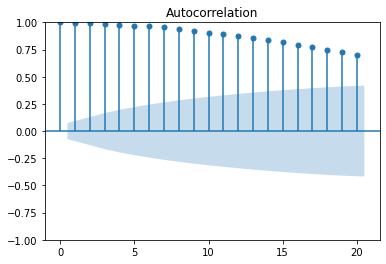

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
acf = plot_acf(train["Total"], lags=20)

In [10]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(ts):
    result = adfuller(ts)
    print(f'p-value: {result[1]}')
    print(f'Lags: {result[2]}')
    print(f'Number of obs: {result[3]}')


In [11]:
adfuller_test(train["Total"])

p-value: 0.07047793614344924
Lags: 20
Number of obs: 669


As seen in the above tests:

1. The ACF plot decreases/declines slowly for different lags
2. The p-value returned by the Augmented Dicky-Fuller (adfuller) test is >0.05

Both of these observations are not consistent with the null hypothesis that the data is stationary. Therefore we **cannot use ARIMA(p,0,q)** or an ARMA model for our time series.

Our next step is to find the order of differencing for our ARIMA model to convert it into stationary data. i.e, to find d-value of the ARIMA(p,d,q) model.


In [12]:
# trying with diff order = 1
train["total_diff"] = train["Total"].diff()

C:\Users\Arunachala\AppData\Local\Temp\ipykernel_14136\1415376927.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
train.head()

,Total,total_diff
2020-01-31,0.0,NaN
2020-02-01,0.0,0.0
2020-02-02,1.0,1.0
2020-02-03,1.0,0.0
2020-02-04,0.0,-1.0


In [14]:
train.dropna(inplace=True)

C:\Users\Arunachala\AppData\Local\Temp\ipykernel_14136\167719433.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train["total_diff"]))

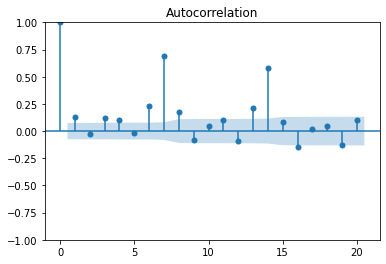

In [16]:
acf = plot_acf(train["total_diff"], lags=20)

In [17]:
adfuller_test(train["total_diff"])

p-value: 4.565258309637875e-06
Lags: 19
Number of obs: 669


In order of differecning 1, we see that:

1. The ACF plot shows no sign of slow decline of autocorrelation over lags. It immediately drops.
2. The p value retuerned by the Dicky-Fuller test is extremely small, and well below the threshold of 0.05.

So with the differencing order of 1, we get a stationary time series data. Therefore we can use **ARIMA(p,1,q)** as our model.

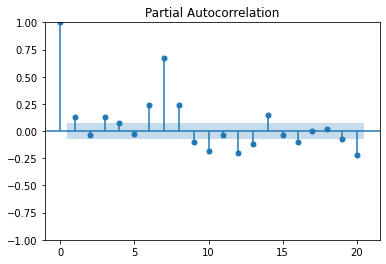

In [18]:
# finding p and q values of new staionary time series
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(train["total_diff"], lags=20, method="ywm")

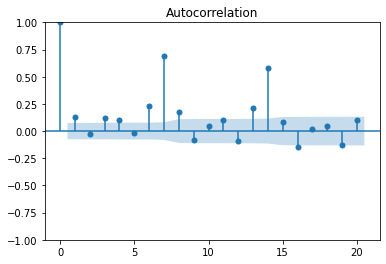

In [19]:
acf = plot_acf(train["total_diff"], lags=20)

### Rules for deciding p and q

#### p value

1. The partial autocorrelation is significant for first p values/lags and then cuts off to zero
2. The ACF decreases exponentially

Point 2 is just a clarifier that the series needs to be stationary for us to select a p-value.
And from our pacf plot we identify that p = 1 (after p/lags=1, it cuts off to zero)

#### q value

1. The Autocorrelation is significant for first q values/lags and then cuts off to zero
2. The PACF decreases exponentially

Again point 2 is just a clarifier that the series needs to be stationary for us to select a q-value. And from our ACF plot we get q = 1

Therefore we have identified our model to be **ARIMA(1,1,1)**

### Checking for seasonality


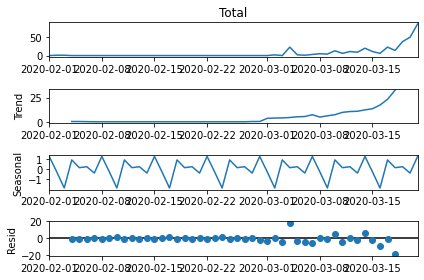

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts_decompose = seasonal_decompose(train["Total"][:50], model="additive")
ts_plot = ts_decompose.plot()

In [21]:
seasonal = ts_decompose.seasonal
fig = px.line(seasonal, title="Seasonality")
fig.show()

In [22]:
adfuller_test(seasonal)

p-value: 0.0
Lags: 7
Number of obs: 42


Therefore D = 0, as seasonal component is already stationary

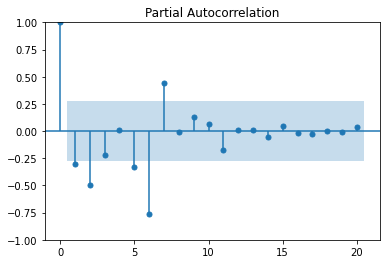

In [23]:
s_pacf = plot_pacf(seasonal, lags=20, method="ywm")

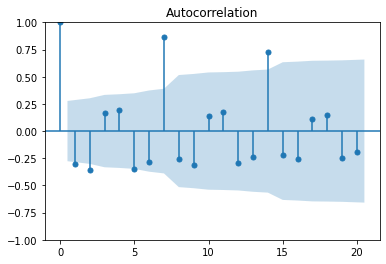

In [24]:
s_acf = plot_acf(seasonal, lags=20)

In [25]:
import statsmodels.api as sm
arima = sm.tsa.statespace.SARIMAX(train['Total'], order=(1,1,1), seasonal_order=(3,0,3,7),)

In [26]:
arima_fit = arima.fit()

In [27]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                     Total   No. Observations:                  689
Model:             SARIMAX(1, 1, 1)x(3, 0, [1, 2, 3], 7)   Log Likelihood               -6886.716
Date:                                   Thu, 10 Mar 2022   AIC                          13791.432
Time:                                           10:28:33   BIC                          13832.236
Sample:                                       02-01-2020   HQIC                         13807.218
                                            - 12-20-2021                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3643      0.239     -1.523      0.128      -0.833       0.105
ma.L1          0.1842      0.252      0.732      0.464      -0.309       0.678
ar.S.L7        0.5595      0.256      2.183      0.029       0.057       1.062
ar.S.L14      -0.6009      0.235     -2.562      0.010      -1.061      -0.141
ar.S.L21       0.6105      0.189      3.231      0.001       0.240       0.981
ma.S.L7        0.0566      0.265      0.214      0.831      -0.463       0.576
ma.S.L14       0.8171      0.164      4.984      0.000       0.496       1.138
ma.S.L21      -0.0956      0.119     -0.804      0.421      -0.329       0.138
sigma2      4.811e+07   8.52e-09   5.65e+15      0.000    4.81e+07    4.81e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              4565.66
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               3.20   Skew:                            -0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.88e+31. Standard errors may be unstable.
"""

In [28]:
pred = arima_fit.predict(start=train.index[-1], end=test.index[-1])

In [29]:
mape = FindErrors(test.Total.values, pred.values[1:]).mape()

In [30]:
mape

70.56188898507266